# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3719168/11490434 [========>.....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:53 - loss: 0.6952

  29/1875 [..............................] - ETA: 3s - loss: 0.5499   

  59/1875 [..............................] - ETA: 3s - loss: 0.4667

  91/1875 [>.............................] - ETA: 3s - loss: 0.4217

 118/1875 [>.............................] - ETA: 3s - loss: 0.3975

 149/1875 [=>............................] - ETA: 2s - loss: 0.3773

 179/1875 [=>............................] - ETA: 2s - loss: 0.3622

 208/1875 [==>...........................] - ETA: 2s - loss: 0.3501

 237/1875 [==>...........................] - ETA: 2s - loss: 0.3399

 267/1875 [===>..........................] - ETA: 2s - loss: 0.3307

 295/1875 [===>..........................] - ETA: 2s - loss: 0.3231

 324/1875 [====>.........................] - ETA: 2s - loss: 0.3160

 354/1875 [====>.........................] - ETA: 2s - loss: 0.3095

 384/1875 [=====>........................] - ETA: 2s - loss: 0.3035

 412/1875 [=====>........................] - ETA: 2s - loss: 0.2984

 437/1875 [=====>........................] - ETA: 2s - loss: 0.2942

 464/1875 [======>.......................] - ETA: 2s - loss: 0.2900

 494/1875 [======>.......................] - ETA: 2s - loss: 0.2856

 522/1875 [=======>......................] - ETA: 2s - loss: 0.2817

 550/1875 [=======>......................] - ETA: 2s - loss: 0.2781

 579/1875 [========>.....................] - ETA: 2s - loss: 0.2746

 610/1875 [========>.....................] - ETA: 2s - loss: 0.2710

 641/1875 [=========>....................] - ETA: 2s - loss: 0.2677

 673/1875 [=========>....................] - ETA: 2s - loss: 0.2645

 706/1875 [==========>...................] - ETA: 2s - loss: 0.2613

 737/1875 [==========>...................] - ETA: 1s - loss: 0.2585

 769/1875 [===========>..................] - ETA: 1s - loss: 0.2557

 798/1875 [===========>..................] - ETA: 1s - loss: 0.2533

 828/1875 [============>.................] - ETA: 1s - loss: 0.2509

 860/1875 [============>.................] - ETA: 1s - loss: 0.2485

 886/1875 [=============>................] - ETA: 1s - loss: 0.2466

 913/1875 [=============>................] - ETA: 1s - loss: 0.2447

 938/1875 [==============>...............] - ETA: 1s - loss: 0.2431

 966/1875 [==============>...............] - ETA: 1s - loss: 0.2412

 997/1875 [==============>...............] - ETA: 1s - loss: 0.2393

1034/1875 [===============>..............] - ETA: 1s - loss: 0.2370

1064/1875 [================>.............] - ETA: 1s - loss: 0.2353

1094/1875 [================>.............] - ETA: 1s - loss: 0.2336

1124/1875 [================>.............] - ETA: 1s - loss: 0.2319

1154/1875 [=================>............] - ETA: 1s - loss: 0.2304

1185/1875 [=================>............] - ETA: 1s - loss: 0.2288

1211/1875 [==================>...........] - ETA: 1s - loss: 0.2275

1239/1875 [==================>...........] - ETA: 1s - loss: 0.2261

1269/1875 [===================>..........] - ETA: 1s - loss: 0.2247

1301/1875 [===================>..........] - ETA: 0s - loss: 0.2233

1333/1875 [====================>.........] - ETA: 0s - loss: 0.2218

1365/1875 [====================>.........] - ETA: 0s - loss: 0.2205

1396/1875 [=====================>........] - ETA: 0s - loss: 0.2192

1423/1875 [=====================>........] - ETA: 0s - loss: 0.2181

1453/1875 [======================>.......] - ETA: 0s - loss: 0.2169

1482/1875 [======================>.......] - ETA: 0s - loss: 0.2158

1511/1875 [=======================>......] - ETA: 0s - loss: 0.2147

1541/1875 [=======================>......] - ETA: 0s - loss: 0.2136

1570/1875 [========================>.....] - ETA: 0s - loss: 0.2126

1599/1875 [========================>.....] - ETA: 0s - loss: 0.2116

1629/1875 [=========================>....] - ETA: 0s - loss: 0.2105

1658/1875 [=========================>....] - ETA: 0s - loss: 0.2096

1687/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1715/1875 [==========================>...] - ETA: 0s - loss: 0.2077

1744/1875 [==========================>...] - ETA: 0s - loss: 0.2068

1773/1875 [===========================>..] - ETA: 0s - loss: 0.2059

1802/1875 [===========================>..] - ETA: 0s - loss: 0.2050

1832/1875 [============================>.] - ETA: 0s - loss: 0.2042

1860/1875 [============================>.] - ETA: 0s - loss: 0.2034

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2029


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1083

  30/1875 [..............................] - ETA: 3s - loss: 0.1119

  59/1875 [..............................] - ETA: 3s - loss: 0.1117

  88/1875 [>.............................] - ETA: 3s - loss: 0.1116

 117/1875 [>.............................] - ETA: 3s - loss: 0.1114

 146/1875 [=>............................] - ETA: 3s - loss: 0.1112

 175/1875 [=>............................] - ETA: 2s - loss: 0.1110

 204/1875 [==>...........................] - ETA: 2s - loss: 0.1108

 232/1875 [==>...........................] - ETA: 2s - loss: 0.1106

 261/1875 [===>..........................] - ETA: 2s - loss: 0.1105

 290/1875 [===>..........................] - ETA: 2s - loss: 0.1104

 319/1875 [====>.........................] - ETA: 2s - loss: 0.1102

 348/1875 [====>.........................] - ETA: 2s - loss: 0.1101

 378/1875 [=====>........................] - ETA: 2s - loss: 0.1100

 407/1875 [=====>........................] - ETA: 2s - loss: 0.1099

 437/1875 [=====>........................] - ETA: 2s - loss: 0.1098

 465/1875 [======>.......................] - ETA: 2s - loss: 0.1097

 490/1875 [======>.......................] - ETA: 2s - loss: 0.1096

 525/1875 [=======>......................] - ETA: 2s - loss: 0.1095

 560/1875 [=======>......................] - ETA: 2s - loss: 0.1094

 589/1875 [========>.....................] - ETA: 2s - loss: 0.1093

 620/1875 [========>.....................] - ETA: 2s - loss: 0.1092

 654/1875 [=========>....................] - ETA: 2s - loss: 0.1091

 685/1875 [=========>....................] - ETA: 2s - loss: 0.1090

 713/1875 [==========>...................] - ETA: 1s - loss: 0.1089

 739/1875 [==========>...................] - ETA: 1s - loss: 0.1089

 766/1875 [===========>..................] - ETA: 1s - loss: 0.1088

 796/1875 [===========>..................] - ETA: 1s - loss: 0.1087

 824/1875 [============>.................] - ETA: 1s - loss: 0.1087

 855/1875 [============>.................] - ETA: 1s - loss: 0.1086

 885/1875 [=============>................] - ETA: 1s - loss: 0.1085

 916/1875 [=============>................] - ETA: 1s - loss: 0.1084

 950/1875 [==============>...............] - ETA: 1s - loss: 0.1083

 982/1875 [==============>...............] - ETA: 1s - loss: 0.1083

1012/1875 [===============>..............] - ETA: 1s - loss: 0.1082

1044/1875 [===============>..............] - ETA: 1s - loss: 0.1081

1078/1875 [================>.............] - ETA: 1s - loss: 0.1080

1114/1875 [================>.............] - ETA: 1s - loss: 0.1079

1148/1875 [=================>............] - ETA: 1s - loss: 0.1079

1179/1875 [=================>............] - ETA: 1s - loss: 0.1078

1210/1875 [==================>...........] - ETA: 1s - loss: 0.1077

1242/1875 [==================>...........] - ETA: 1s - loss: 0.1077

1277/1875 [===================>..........] - ETA: 1s - loss: 0.1076

1314/1875 [====================>.........] - ETA: 0s - loss: 0.1075

1341/1875 [====================>.........] - ETA: 0s - loss: 0.1074

1368/1875 [====================>.........] - ETA: 0s - loss: 0.1074

1395/1875 [=====================>........] - ETA: 0s - loss: 0.1073

1423/1875 [=====================>........] - ETA: 0s - loss: 0.1073

1453/1875 [======================>.......] - ETA: 0s - loss: 0.1072

1482/1875 [======================>.......] - ETA: 0s - loss: 0.1072

1510/1875 [=======================>......] - ETA: 0s - loss: 0.1071

1537/1875 [=======================>......] - ETA: 0s - loss: 0.1071

1568/1875 [========================>.....] - ETA: 0s - loss: 0.1070

1604/1875 [========================>.....] - ETA: 0s - loss: 0.1069

1639/1875 [=========================>....] - ETA: 0s - loss: 0.1069

1670/1875 [=========================>....] - ETA: 0s - loss: 0.1068

1705/1875 [==========================>...] - ETA: 0s - loss: 0.1067

1734/1875 [==========================>...] - ETA: 0s - loss: 0.1067

1762/1875 [===========================>..] - ETA: 0s - loss: 0.1066

1787/1875 [===========================>..] - ETA: 0s - loss: 0.1066

1818/1875 [============================>.] - ETA: 0s - loss: 0.1065

1844/1875 [============================>.] - ETA: 0s - loss: 0.1065

1874/1875 [============================>.] - ETA: 0s - loss: 0.1064

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1064


Epoch 3/5
   1/1875 [..............................] - ETA: 14s - loss: 0.1054

  33/1875 [..............................] - ETA: 2s - loss: 0.0993 

  65/1875 [>.............................] - ETA: 2s - loss: 0.0991

  93/1875 [>.............................] - ETA: 2s - loss: 0.0991

 124/1875 [>.............................] - ETA: 2s - loss: 0.0990

 157/1875 [=>............................] - ETA: 2s - loss: 0.0989

 185/1875 [=>............................] - ETA: 2s - loss: 0.0989

 210/1875 [==>...........................] - ETA: 2s - loss: 0.0988

 234/1875 [==>...........................] - ETA: 2s - loss: 0.0987

 260/1875 [===>..........................] - ETA: 2s - loss: 0.0986

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0986

 307/1875 [===>..........................] - ETA: 2s - loss: 0.0985

 330/1875 [====>.........................] - ETA: 2s - loss: 0.0985

 353/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 376/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 398/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 421/1875 [=====>........................] - ETA: 2s - loss: 0.0983

 444/1875 [======>.......................] - ETA: 2s - loss: 0.0983

 471/1875 [======>.......................] - ETA: 2s - loss: 0.0983

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0983

 529/1875 [=======>......................] - ETA: 2s - loss: 0.0983

 556/1875 [=======>......................] - ETA: 2s - loss: 0.0983

 582/1875 [========>.....................] - ETA: 2s - loss: 0.0983

 608/1875 [========>.....................] - ETA: 2s - loss: 0.0983

 632/1875 [=========>....................] - ETA: 2s - loss: 0.0982

 656/1875 [=========>....................] - ETA: 2s - loss: 0.0982

 679/1875 [=========>....................] - ETA: 2s - loss: 0.0982

 703/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 726/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 752/1875 [===========>..................] - ETA: 2s - loss: 0.0982

 776/1875 [===========>..................] - ETA: 2s - loss: 0.0982

 800/1875 [===========>..................] - ETA: 2s - loss: 0.0982

 824/1875 [============>.................] - ETA: 2s - loss: 0.0982

 849/1875 [============>.................] - ETA: 2s - loss: 0.0981

 875/1875 [=============>................] - ETA: 2s - loss: 0.0981

 901/1875 [=============>................] - ETA: 1s - loss: 0.0981

 927/1875 [=============>................] - ETA: 1s - loss: 0.0981

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0981

 979/1875 [==============>...............] - ETA: 1s - loss: 0.0981

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1028/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1053/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1073/1875 [================>.............] - ETA: 1s - loss: 0.0981

1097/1875 [================>.............] - ETA: 1s - loss: 0.0981

1122/1875 [================>.............] - ETA: 1s - loss: 0.0981

1146/1875 [=================>............] - ETA: 1s - loss: 0.0981

1170/1875 [=================>............] - ETA: 1s - loss: 0.0981

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1217/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1240/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1265/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1290/1875 [===================>..........] - ETA: 1s - loss: 0.0980

1313/1875 [====================>.........] - ETA: 1s - loss: 0.0980

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0980

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0980

1391/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1443/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1466/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1513/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1540/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1736/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1838/1875 [============================>.] - ETA: 0s - loss: 0.0979

1862/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0991

  27/1875 [..............................] - ETA: 3s - loss: 0.0963

  49/1875 [..............................] - ETA: 3s - loss: 0.0963

  78/1875 [>.............................] - ETA: 3s - loss: 0.0963

 102/1875 [>.............................] - ETA: 3s - loss: 0.0962

 131/1875 [=>............................] - ETA: 3s - loss: 0.0962

 155/1875 [=>............................] - ETA: 3s - loss: 0.0962

 185/1875 [=>............................] - ETA: 3s - loss: 0.0962

 207/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 229/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 254/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 278/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 299/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 324/1875 [====>.........................] - ETA: 3s - loss: 0.0962

 348/1875 [====>.........................] - ETA: 3s - loss: 0.0962

 376/1875 [=====>........................] - ETA: 3s - loss: 0.0962

 399/1875 [=====>........................] - ETA: 3s - loss: 0.0962

 425/1875 [=====>........................] - ETA: 3s - loss: 0.0962

 449/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 470/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 496/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 520/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 545/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 614/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 664/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 688/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 713/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 738/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 760/1875 [===========>..................] - ETA: 2s - loss: 0.0963

 779/1875 [===========>..................] - ETA: 2s - loss: 0.0963

 804/1875 [===========>..................] - ETA: 2s - loss: 0.0963

 828/1875 [============>.................] - ETA: 2s - loss: 0.0963

 857/1875 [============>.................] - ETA: 2s - loss: 0.0963

 886/1875 [=============>................] - ETA: 2s - loss: 0.0963

 913/1875 [=============>................] - ETA: 2s - loss: 0.0963

 939/1875 [==============>...............] - ETA: 1s - loss: 0.0963

 960/1875 [==============>...............] - ETA: 1s - loss: 0.0963

 983/1875 [==============>...............] - ETA: 1s - loss: 0.0963

1007/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1036/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1065/1875 [================>.............] - ETA: 1s - loss: 0.0963

1093/1875 [================>.............] - ETA: 1s - loss: 0.0963

1119/1875 [================>.............] - ETA: 1s - loss: 0.0963

1149/1875 [=================>............] - ETA: 1s - loss: 0.0963

1174/1875 [=================>............] - ETA: 1s - loss: 0.0963

1202/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1225/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1250/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1274/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1300/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0963

1350/1875 [====================>.........] - ETA: 1s - loss: 0.0963

1374/1875 [====================>.........] - ETA: 1s - loss: 0.0963

1399/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1449/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1525/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1595/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0963

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0963

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1734/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1818/1875 [============================>.] - ETA: 0s - loss: 0.0962

1844/1875 [============================>.] - ETA: 0s - loss: 0.0962

1866/1875 [============================>.] - ETA: 0s - loss: 0.0962

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0962


Epoch 5/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0930

  23/1875 [..............................] - ETA: 4s - loss: 0.0954

  48/1875 [..............................] - ETA: 3s - loss: 0.0950

  73/1875 [>.............................] - ETA: 3s - loss: 0.0949

 101/1875 [>.............................] - ETA: 3s - loss: 0.0948

 126/1875 [=>............................] - ETA: 3s - loss: 0.0948

 153/1875 [=>............................] - ETA: 3s - loss: 0.0949

 181/1875 [=>............................] - ETA: 3s - loss: 0.0950

 206/1875 [==>...........................] - ETA: 3s - loss: 0.0950

 231/1875 [==>...........................] - ETA: 3s - loss: 0.0951

 254/1875 [===>..........................] - ETA: 3s - loss: 0.0951

 280/1875 [===>..........................] - ETA: 3s - loss: 0.0951

 303/1875 [===>..........................] - ETA: 3s - loss: 0.0951

 322/1875 [====>.........................] - ETA: 3s - loss: 0.0952

 348/1875 [====>.........................] - ETA: 3s - loss: 0.0952

 374/1875 [====>.........................] - ETA: 3s - loss: 0.0952

 398/1875 [=====>........................] - ETA: 3s - loss: 0.0952

 422/1875 [=====>........................] - ETA: 3s - loss: 0.0952

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 469/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 497/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 553/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 582/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 608/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 631/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 657/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 688/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 713/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 743/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 772/1875 [===========>..................] - ETA: 2s - loss: 0.0953

 803/1875 [===========>..................] - ETA: 2s - loss: 0.0953

 833/1875 [============>.................] - ETA: 2s - loss: 0.0953

 863/1875 [============>.................] - ETA: 1s - loss: 0.0953

 894/1875 [=============>................] - ETA: 1s - loss: 0.0953

 926/1875 [=============>................] - ETA: 1s - loss: 0.0953

 957/1875 [==============>...............] - ETA: 1s - loss: 0.0953

 987/1875 [==============>...............] - ETA: 1s - loss: 0.0953

1016/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1048/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1079/1875 [================>.............] - ETA: 1s - loss: 0.0953

1110/1875 [================>.............] - ETA: 1s - loss: 0.0953

1140/1875 [=================>............] - ETA: 1s - loss: 0.0953

1170/1875 [=================>............] - ETA: 1s - loss: 0.0953

1199/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1228/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1257/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1316/1875 [====================>.........] - ETA: 1s - loss: 0.0953

1343/1875 [====================>.........] - ETA: 0s - loss: 0.0953

1373/1875 [====================>.........] - ETA: 0s - loss: 0.0953

1402/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1447/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1533/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1558/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1584/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1611/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1833/1875 [============================>.] - ETA: 0s - loss: 0.0954

1863/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

Matplotlib is building the font cache; this may take a moment.


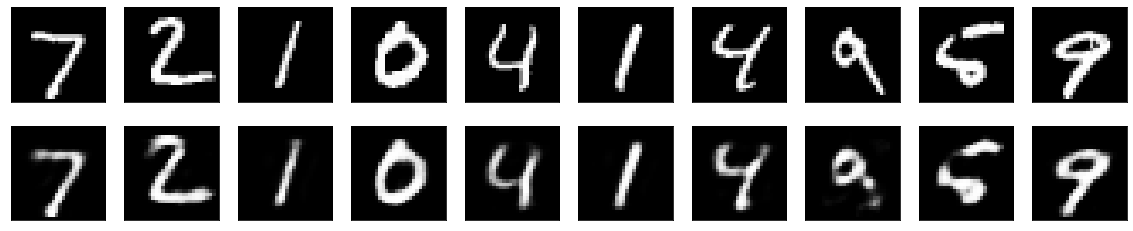

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
